see `/Users/mwilde/Dropbox/slime-mold/final_code/peng_plot.ipynb`

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
import numpy as np
from astropy.table import Table, vstack, hstack
import pandas as pd
from scipy import stats as sstats
import astropy.units as u
from astropy.coordinates import SkyCoord
from matplotlib import pyplot as plt


In [2]:
def xmatch(table1,
           table2,
           ra1_key,
           dec1_key,
           ra2_key,
           dec2_key,
           units='deg',
           max_sep=1.0 * u.arcsec):
    # convert to astropy
    if not isinstance(table1, Table):
        if isinstance(table1, pd.DataFrame):
            table1 = Table.from_pandas(table1)
        else:
            print('table1 must be pandas or astropy table')

    if not isinstance(table2, Table):
        if isinstance(table2, pd.DataFrame):
            table2 = Table.from_pandas(table2)
        else:
            print('table2 must be pandas or astropy table')

    ra1 = np.array(table1[ra1_key])
    dec1 = np.array(table1[dec1_key])
    ra2 = np.array(table2[ra2_key])
    dec2 = np.array(table2[dec2_key])

    c1 = SkyCoord(ra=ra1, dec=dec1, unit=units)
    c2 = SkyCoord(ra=ra2, dec=dec2, unit=units)

    # find the closest match
    idx, d2d, _ = c1.match_to_catalog_sky(c2, nthneighbor=1)

    sep_constraint = d2d < max_sep
    t1_matches = table1[sep_constraint]
    t2_matches = table2[idx[sep_constraint]]

    comb_tab = hstack([t1_matches, t2_matches])

    # add ang_sep
    comb_tab['ang_sep'] = d2d[sep_constraint].arcsec
    return comb_tab

# load file with galaxy properties
you can use your own here as long as it has ra, dec or you can combine catalogID,plate,mjd/fiberid to create unique identifier. This should have been done but there were errors in the firefly catalogIDs

In [3]:
nsafile = '/Users/mwilde/Dropbox/slime-mold/NSA_v1p0p1_derived.fits'
nsa = Table.read(nsafile)

# load slime catalog
only select the low z galaxy sample made with all galaxy types (not only LRG catalogs). you can find this file at https://data.sdss.org/sas/dr17/env/EBOSS_LSS/mcpm/v1_0_0/slimeMold_galaxy_catalog_v1_0_0.fits

In [4]:
vacfile = "/Users/mwilde/Desktop/slimeMold_galaxy_catalog_v1_0_0.fits"
vac = Table.read(vacfile)
vac = vac[vac['mcpmRun'] == 0]
vac

catalogID,plate,mjd,fiberid,ra,dec,z,massSource,mcpmRun,mstars,matterDens
int64,int32,int32,int32,float64,float64,float32,bool,int16,float32,float32
26651630147,266,51630,147,146.29986258871986,-0.1200040329025857,0.030703507,True,0,10.425013,1.4974102
266516301,266,51630,1,146.714215072841,-1.041280023331374,0.021222278,True,0,10.172931,1.7854924
2665163012,266,51630,12,146.9634997327016,-0.5447758299302171,0.055980586,True,0,10.012631,0.8528137
2665163069,266,51630,69,146.8915925363065,-0.5126719548057409,0.08389291,True,0,10.379661,0.72258246
2665163083,266,51630,83,146.0937040634269,-0.793110365699979,0.06758517,True,0,10.851116,0.98676234
26651630373,266,51630,373,145.79337611029078,1.185684949627377,0.06256682,True,0,10.554297,0.49502164
2665163078,266,51630,78,146.7560335057309,-0.1682299117202801,0.062449906,True,0,9.977581,1.092552
26651630412,266,51630,412,145.96965802752655,0.8309221318276753,0.03635695,True,0,10.113277,1.608144
26651630221,266,51630,221,145.7447381357765,-0.0763446750654876,0.06259136,True,0,10.18631,1.1111013


# match the two catalogs based on ra, dec
there should be a better way to do this...

In [5]:
combo = xmatch(nsa, vac, ra1_key='RA', dec1_key='DEC', ra2_key='ra', dec2_key='dec')

# define sSFR, mass, density variables

In [6]:
uvssfr = np.log10(combo['SFR_UV']) - combo['mstars_1']
mstars = combo['mstars_1']
densvals = combo['matterDens']

<ipython-input-6-262258a7b451>:1: RuntimeWarning: divide by zero encountered in log10
  uvssfr = np.log10(combo['SFR_UV']) - combo['mstars_1']


# bin the results in 2D.
might wanna fuss with the ranges when making various plots

In [7]:
# densvals = galtrace
# envbins = np.arange(0.5,1701,25)
# logenvbins = np.arange(-0.7, 10, 0.05)
# logenvbins = np.arange(2, 12, 0.075)
logenvbins = np.arange(-0.25, 2.5, 0.05)
massbins = np.arange(8.3, 11.51, 0.1)
notnan = ~np.isnan(uvssfr)
bsresult_sSFR = sstats.binned_statistic_2d(mstars[notnan],
                                           densvals[notnan],
                                           uvssfr[notnan],
                                           bins=[massbins, logenvbins],
                                           statistic='median')

# plot the figure

<ipython-input-8-f57419b861fa>:20: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow(bsresult_sSFR[0].T,


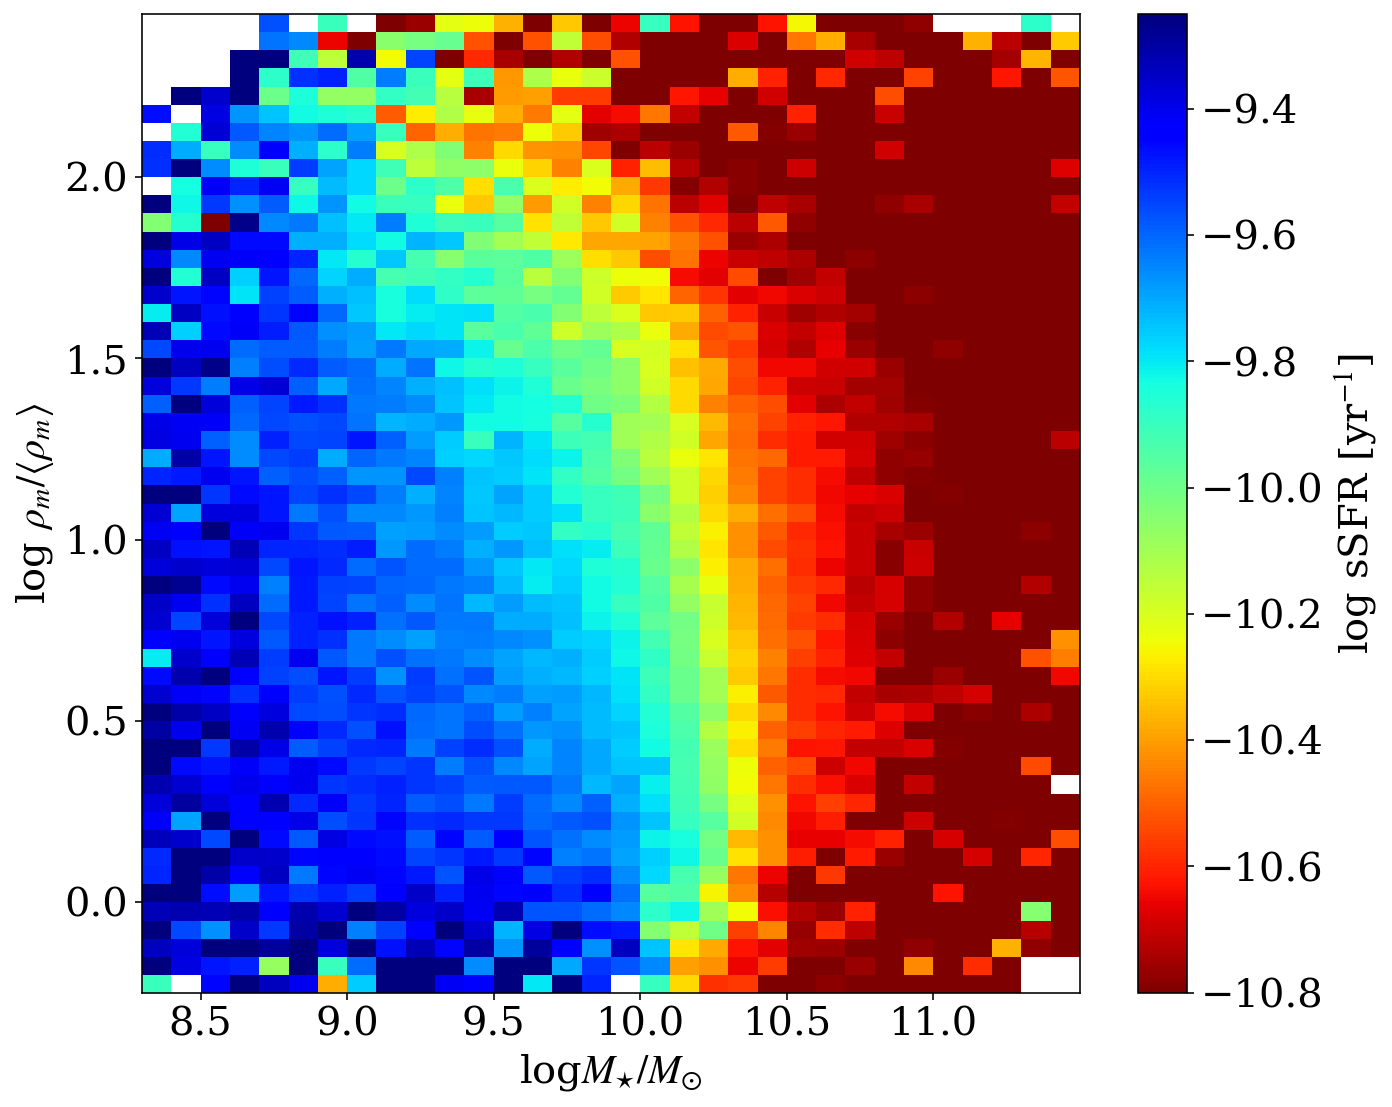

In [8]:
from matplotlib import colors as mpcolors
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Times'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 20
#plt.rcParams['figure.subplot.top']=0.95
#plt.rcParams['figure.subplot.bottom']=0.08
#plt.rcParams['figure.subplot.left']=0.12
#plt.rcParams['figure.subplot.right']=0.94
thresh = [0,4]
norm = mpcolors.Normalize(thresh[0], thresh[1])

colormap='jet_r'
cmap = plt.get_cmap(colormap)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig = plt.figure(figsize=(10.5,9))
ax = fig.add_subplot(111)
im = ax.imshow(bsresult_sSFR[0].T,
               origin='lower',
               cmap=colormap,
               vmin=-10.8,
               vmax=-9.25,
               extent=[massbins[0], massbins[-1], logenvbins[0], logenvbins[-1]],
               norm=norm)

cb = fig.colorbar(sm)
ax.set_xticks(np.arange(8.5,11.5,0.5))

ax.set_aspect('auto')
ax.set_xlabel(r'log$M_{\star} / M_{\odot}$')
ax.set_ylabel(r'log $\rho_m / \langle \rho_m \rangle$')
cb.ax.set_ylabel(r'log sSFR [yr$^{-1}$]')
plt.savefig('../figures/peng_plot.pdf', dpi=300)
